# Chap02 - More PyMC

## 2.1 서론

- `PyMC` 구문과 디자인 패턴에 대해 알 수 있다.
- 베이지안 관점에서 시스템을 모델링 하는 방법을 알 수 있다.
- 베이지안 모델의 적합도 평가 및 데이터 시각화 기법을 알 수 있다.

### 2.1.1 부모와 자식 관계

> **부모변수**(Parent variable)는 다른 변수에 영항을 주는 변수다.

> **자식변수**(Child variable)는 다른 변수의 영향을 받는 즉, 부모변수에 종속된다.

어느 변수라도 부모변수가 될 수 있고, 동시에 자식변수가 될 수 있다.

In [9]:
import pymc as pm
import matplotlib

matplotlib.rc('font', family='NanumGothic')  # linux
# matplotlib.rc('font', family='AppleGothic')  # Mac

lambda_ = pm.Exponential('poisson_param', 1)
# 다음 변수 호출에 사용된다.
# lambda_는 data_generator의 부모변수다.
data_generator = pm.Poisson('data_generator', lambda_)
# data_generator는 data_plus_one의 부모변수다
data_plus_one = data_generator + 1

In [10]:
print("Children of 'lambda_': \n", lambda_.children)
print("\nParents of 'data_generator': \n", data_generator.parents)
print("\nChildren of 'data_generator': \n", data_generator.children)

Children of 'lambda_': 
 {<pymc.distributions.new_dist_class.<locals>.new_class 'data_generator' at 0x7fbb94b6a080>}

Parents of 'data_generator': 
 {'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'poisson_param' at 0x7fbb95348fd0>}

Children of 'data_generator': 
 {<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x7fbb94b6a0f0>}


### 2.1.2 `PyMC` 변수

모든 `PyMC`변수는 `value` 속성을 가진다. 이 속성을 통해 변수의 **현재값**(random한 값)을 생성한다.

자식변수(child variable)의 값은 부모변수 값이 주어질 때 변경된다.

In [11]:
print('lambda_.value =', lambda_.value)
print('data_generator.value =', data_generator.value)
print('data_plus_one.value =', data_plus_one.value)

lambda_.value = 2.528924638250493
data_generator.value = 3
data_plus_one.value = 4


`PyMC`은 `stochastic`과 `deterministic` 두 가지 변수를 가진다.
- `stochastic` 변수는 값이 정해지지 않은 변수로 Random(난수)이며 `Poisson, DiscreteUniform, Exponential` 클래스의 인스턴스가 있다.
- `deterministic` 변수는 고정된(?) 값이다. 

#### stochastic 변수 초기화

```python
some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)
```

`0, 4`는 `DiscreteUniform`의 난수 하한선과 상한선이다. `name` arg는 분석 후반에 사후확률분포를 가져올 때 사용하므로 이름을 사용하는 것이 좋다.

In [12]:
# ??를 이용해 확인하기
??pm.DiscreteUniform

Init signature: pm.DiscreteUniform(*args, **kwds)
Docstring:     
D = DiscreteUniform(name, lower, upper, value=None, observed=False, size=1, trace=True, rseed=True, doc=None, verbose=-1, debug=False)

Stochastic variable with DiscreteUniform distribution.
Parents are: lower, upper.

Docstring of log-probability function:

    Discrete uniform log-likelihood.

    .. math::
        f(x \mid lower, upper) = \frac{1}{upper-lower}

    :Parameters:
      - `x` : [int] :math:`lower \leq x \leq upper`
      - `lower` : Lower limit.
      - `upper` : Upper limit (upper > lower).

    
File:           ~/miniconda3/envs/study/lib/python3.6/site-packages/pymc/distributions.py
Type:           StochasticMeta


In [13]:
some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)
print('stochastic :', some_variable.value)

stochastic : 3


변수를 여러개를 랜덤하게 출력하고 싶을 경우 `size` keyword를 이용하여 독립적인 확률변수의 리스트가 만들어 진다.

In [14]:
betas = pm.Uniform('betas', 0, 1, size=10)
print('betas :', betas.value)
# ??pm.Uniform

betas : [0.15636998 0.99885753 0.38749295 0.71651636 0.64643511 0.27776797
 0.13878475 0.39545555 0.84230789 0.80012411]


#### `random()` 호출하기

`stochastic` 변수의 `random()` 메소드를 호출하여 새 난수값을 만들 수 있다.

In [15]:
lambda_1 = pm.Exponential("lambda_1", 1)
lambda_2 = pm.Exponential('lambda_2', 1)
tau = pm.DiscreteUniform('tau', lower=0, upper=10)

print("Initialized values...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value, "\n")
print(lambda_1.random(), lambda_2.random(), tau.random())
print("After calling random() on the variables...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value)

Initialized values...
lambda_1.value = 1.439
lambda_2.value = 1.570
tau.value = 10.000 

0.1380347812929789 0.3885001825670668 10
After calling random() on the variables...
lambda_1.value = 0.138
lambda_2.value = 0.389
tau.value = 10.000


#### deterministic 변수

deterministic 변수는 아래와 같이 **데코레이터**를 이용해 정의해 줄 수 있다.

```python
@pm.deterministic
def some_deterministic_var(v1=v1, ):
    # type code here
```

In [16]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [17]:
# sample code : 1장 1.4 참고
import numpy as np

n_data_points = 5

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

위의 식에서 $\tau, \lambda_1, \lambda_2$를 안다면 $\lambda$를 알 수 있는 것은 당연한 사실이다. 따라서 $\lambda$는 deterministic 변수이다.

`deterministic` 데코레이터 내부에서 stochastic 변수는 stochastic 변수가 아니라 스칼라나 `numpy` 배열 처럼 작동한다. 

In [18]:
some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)

@pm.deterministic
def some_deterministic(stoch=some_variable):  # 함수 작성 시 반드시 kwarg를 사용해야 한다. 
    # stoch.value**2 일 경우 AttributeError가 발생한다. 
    return stoch**2

### 2.1.3 모델에 관측 포함하기

예를 들어 $\lambda_1$에 대한 사전확률분포를 살펴보자

(0, 8)

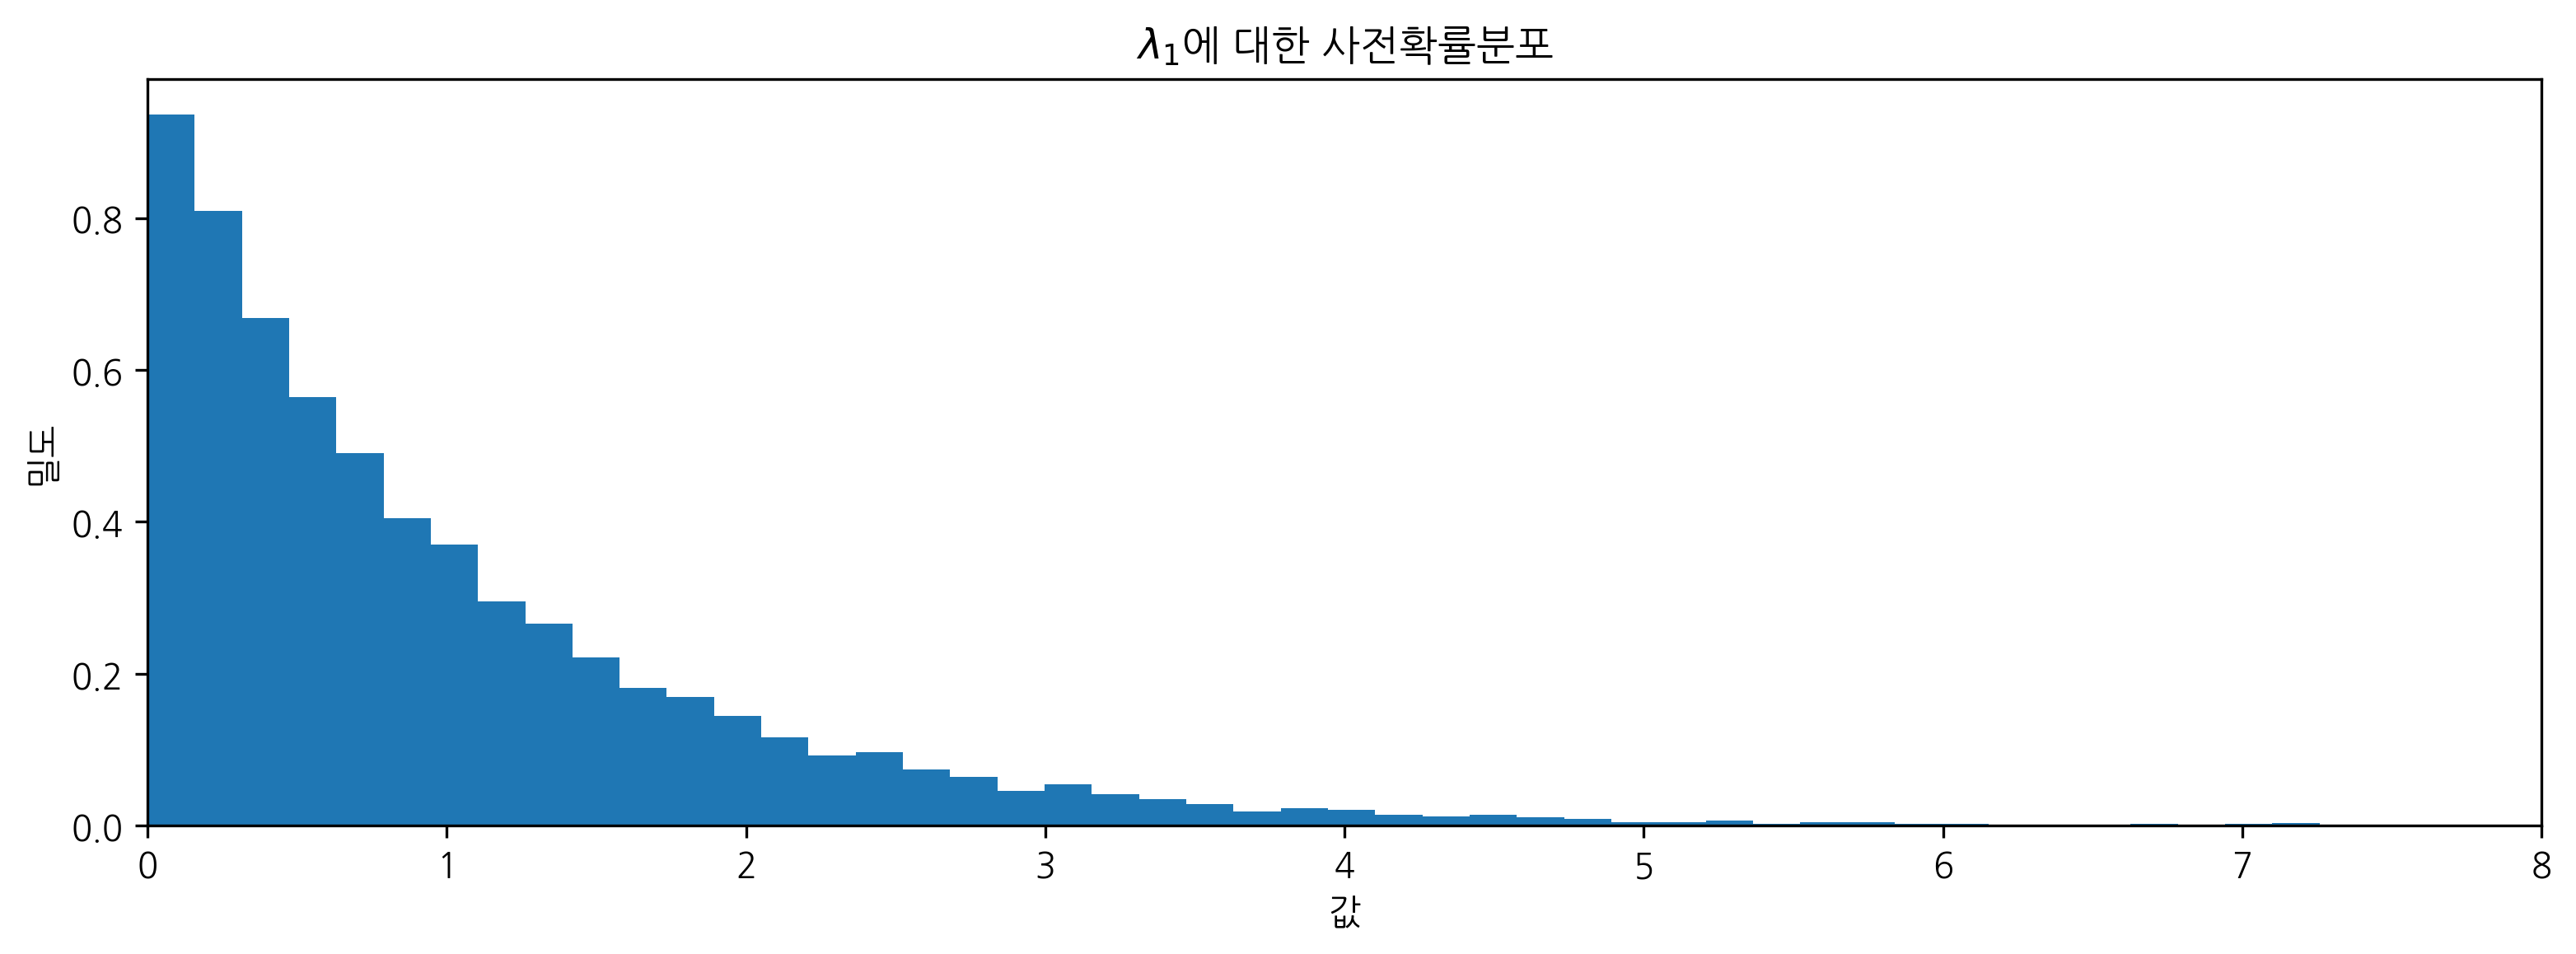

In [19]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

lambda_1 = pm.Exponential("lambda_1", 1)
samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, density=True, histtype='stepfilled')
plt.title('$\lambda_1$에 대한 사전확률분포')
plt.xlabel('값')
plt.ylabel('밀도')
plt.xlim(0, 8)

사전확률분포를 알아보았으니, 데이터/증거/관측치 $X$를 모델에 포함시켜 보자.

`PyMC` 확률변수는 boolean을 받는 kwarg인 `observed`가 있다. 이 `observed`의 역할은 변수의 현재값을 고정하는 즉, 값을 변경 불가능하게 만든다.

In [20]:
data = np.array([10, 5])
fixed_variable = pm.Poisson('fxd', 1, value=data, observed=True)

print('value:', fixed_variable.value)
print("calling .random()")
fixed_variable.random()
print("value: ", fixed_variable.value)

value: [10  5]
calling .random()
value:  [10  5]


In [21]:
# sample code

data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson('obs', lambda_, value=data, observed=True)
print(obs.value)

[10 25 15 20 35]


### 2.1.4 마지막으로

1.4에서 문자메시지 예제 데이터를 통해 모델링을 했을 때, `pm.Model` 클래스로 만들었다. 

이러한 `Model` 클래스를 사용하여 변수를 하나의 단위로 분석할 수 있다.

In [22]:
# sample code
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])
model

## 2.2 모델링 방법

베이지안 모델링을 시작할 때 분석할 **데이터가 어떻게 만들어졌는지** 생각해 보는 것이 좋다.

1장에서 보았던 문자 메시지 데이터에 대해 살펴보자.

1. 먼저, '개수 데이터를 나타내는 최고의 확률변수는 무엇인가?'에서 푸아송분포를 따른다고 가정 하였고, 이를 가지고 푸아송분포에서 표본으로 얻은 문자 메시지 개수를 모델링 한다.
2. '푸아송 분포를 위해 필요한 것은 무엇인가?'에 대해서는 푸아송분포는 모수 $\lambda$를 가진다.
3. 우리는 $\lambda$가 무엇인지 알지 못한다. $\lambda$가 **두 개** 있다고 가정하고 $\lambda$가 바뀌는 시점을 변환점 $\tau$라고 한다.
4. '이 두 $\lambda$에 대해 바람직한 확률분포는 무엇인가?' 에서 지수확률분포를 따른다고 가정한다.
5. 이 지수확률분포는 모수 $\alpha$를 가진다. 우리는 모수 $\alpha$를 알지 못한다. 우리가 추론하고자 하는 것은 $\lambda$ 이므로 $\alpha$의 모델링은 하지 않는다.
6. 또한, 우리는 $\tau$를 알지 못하므로, $\tau$는 전체 기간 동안 이산균등분포에서 나왔다고 가정한다.

이를 시각화하면 다음과 같다.

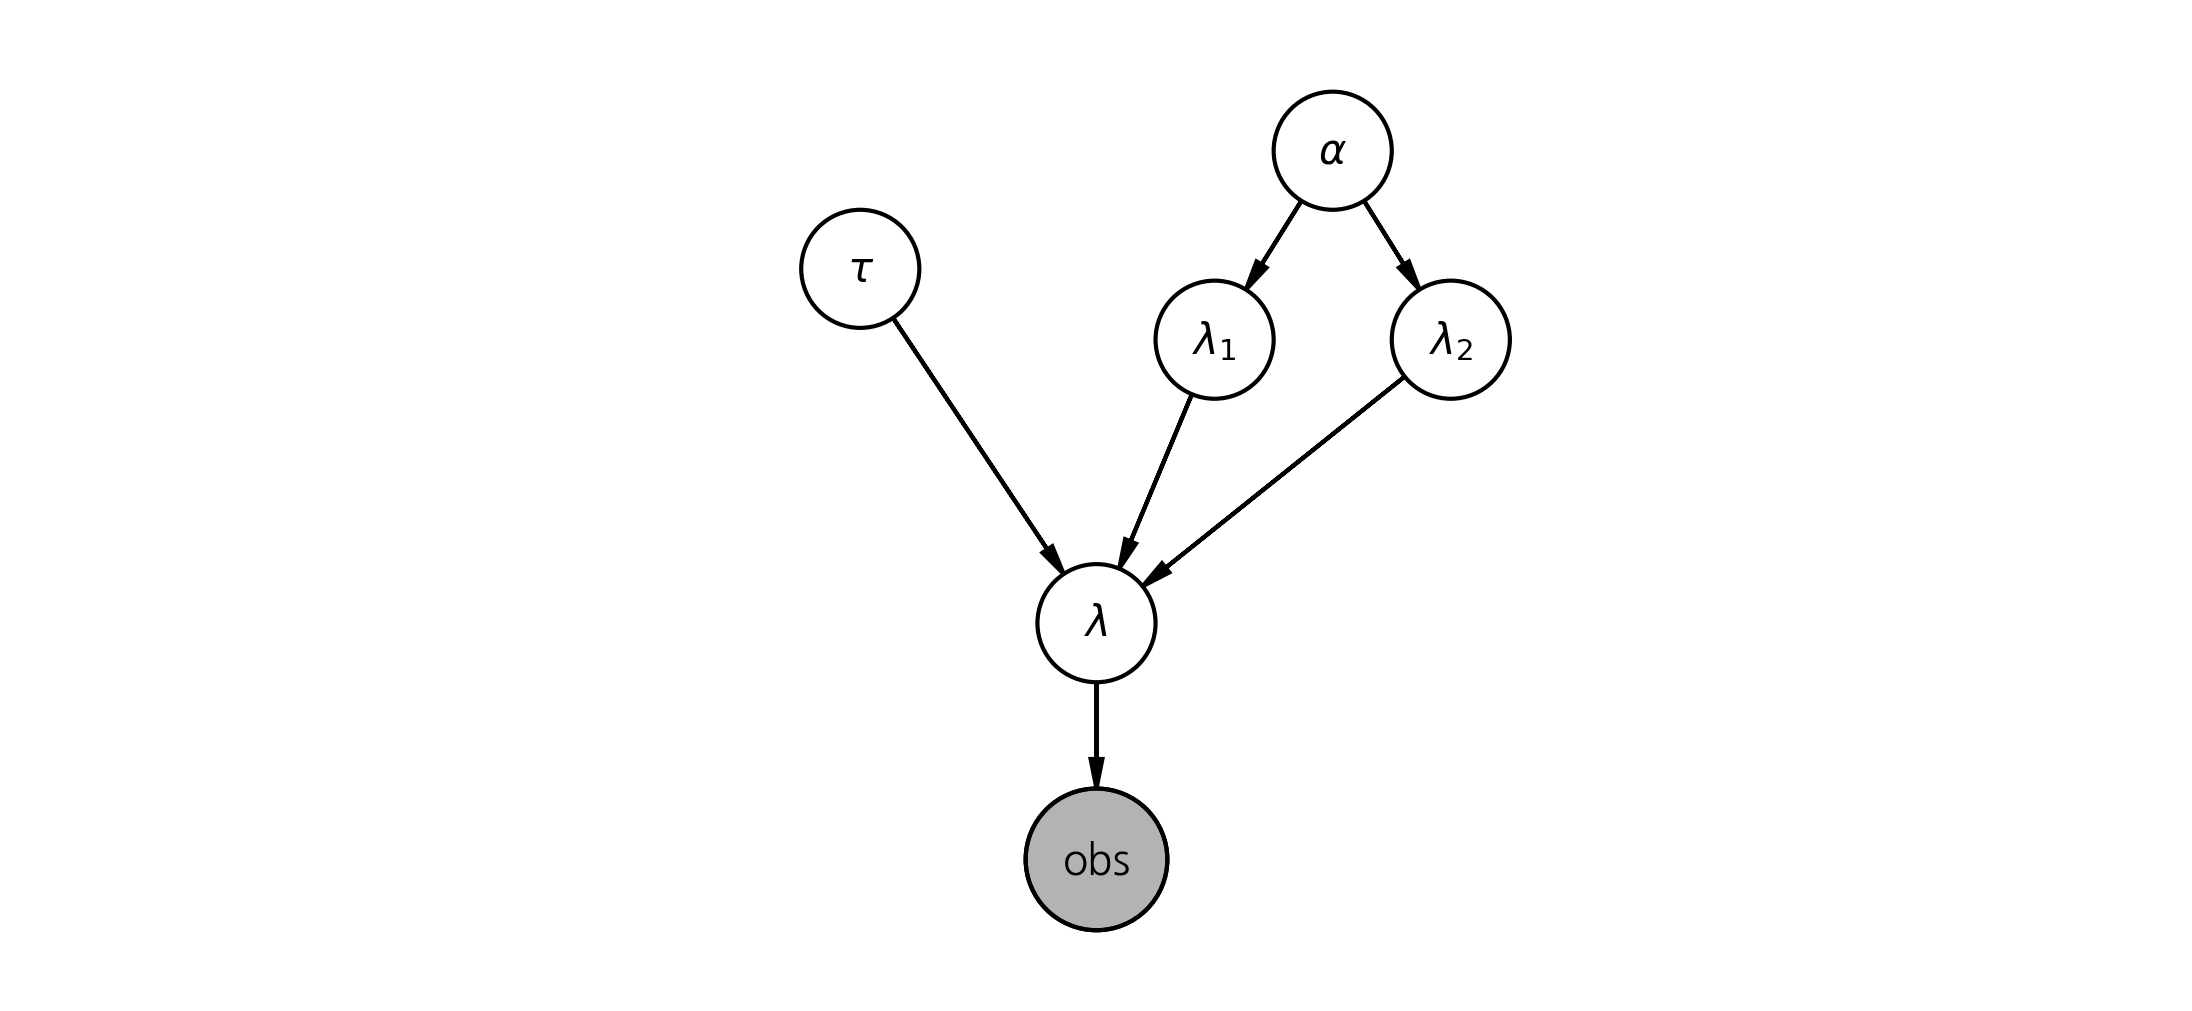

<Figure size 3600x1500 with 0 Axes>

In [23]:
import daft  # pip install daft

pgm = daft.PGM([9, 4], origin=[.5,.5])
pgm.add_node(daft.Node("tau", r"$\tau$", 4.0, 3.5))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 6, 4.0))
pgm.add_node(daft.Node("lambda1", r"$\lambda_1$", 5.5, 3.2,))
pgm.add_node(daft.Node("lambda2", r"$\lambda_2$", 6.5, 3.2))
pgm.add_node(daft.Node("lambda", r"$\lambda$", 5.0, 2.0))
pgm.add_node(daft.Node("obs", "obs", 5.0, 1.0, 1.2, observed=True))



pgm.add_edge("tau", "lambda")
pgm.add_edge("alpha", "lambda1")
pgm.add_edge("alpha", "lambda2")
pgm.add_edge("lambda1", "lambda")
pgm.add_edge("lambda2", "lambda")

pgm.add_edge("lambda", "obs")
pgm.render()
plt.figure( figsize=(12,5) )
plt.show()

### 2.2.1 같은 스토리, 다른 결말

위의 6가지 단계를 반대로 뒤집어 재해석 하면 데이터셋의 실현 가능성을 시뮬레이션할 수 있다. 

다음과 같이 6가지 단계를 반대로 뒤집어 각 단계별로 살펴보자 

1) `DiscreteUniform(0, 80)` 에서 표본을 추출하여 변화 시점인 $\tau$를 명시한다.

In [24]:
??pm.rdiscrete_uniform

Signature: pm.rdiscrete_uniform(lower, upper, size=None)
Source:   
@randomwrap
def rdiscrete_uniform(lower, upper, size=None):
    """
    Random discrete_uniform variates.
    """
    return np.random.randint(lower, upper + 1, size)
File:      ~/miniconda3/envs/study/lib/python3.6/site-packages/pymc/distributions.py
Type:      function


In [25]:
tau = pm.rdiscrete_uniform(0, 80)
print(tau)

25


2) $Exp(\alpha)$ 분포에서 $\lambda_1$과 $\lambda_2$를 뽑는다.

In [26]:
??pm.rexponential

Signature: pm.rexponential(beta, size=None)
Source:   
@randomwrap
def rexponential(beta, size=None):
    """
    Exponential random variates.
    """

    return np.random.exponential(1. / beta, size)
File:      ~/miniconda3/envs/study/lib/python3.6/site-packages/pymc/distributions.py
Type:      function


In [27]:
alpha = 1./20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print(lambda_1, lambda_2)

63.78481351415103 9.940855290376602


3) $\tau$ 이전 며칠 동안 $\lambda = \lambda_1$이고, $\tau$ 이후 며칠 동안 $\lambda = \lambda_2$ 이다.

In [28]:
# ??np.r_
lambda_ = np.r_[lambda_1*np.ones(tau), lambda_2*np.ones(80-tau)]
print(lambda_)

[63.78481351 63.78481351 63.78481351 63.78481351 63.78481351 63.78481351
 63.78481351 63.78481351 63.78481351 63.78481351 63.78481351 63.78481351
 63.78481351 63.78481351 63.78481351 63.78481351 63.78481351 63.78481351
 63.78481351 63.78481351 63.78481351 63.78481351 63.78481351 63.78481351
 63.78481351  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529
  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529
  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529
  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529
  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529
  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529
  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529
  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529
  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529  9.94085529
  9.94085529  9.94085529]


4) $\tau$ 이후 며칠동안 $Poi(\lambda_1)$에서 표본추출하고, $Poi(\lambda_2)$에서 표본추출한다.

In [29]:
# ??pm.rpoisson

In [30]:
data = pm.rpoisson(lambda_)
print(data)

[65 63 60 63 66 68 71 69 57 57 62 73 64 66 74 60 63 62 62 66 60 60 77 53
 57 14  9 15  8  7  7  8 12  9 10 14 10  8 12 12  8 10  5 10 10 11 12 11
  9  8  7  7  9  8 12  3  7 11 14 13  9 16  6  9  8  9  9 10 10  6  6 15
 11  6 10  7 14 10  2 11]


5) 가상의 데이터셋을 그린다.

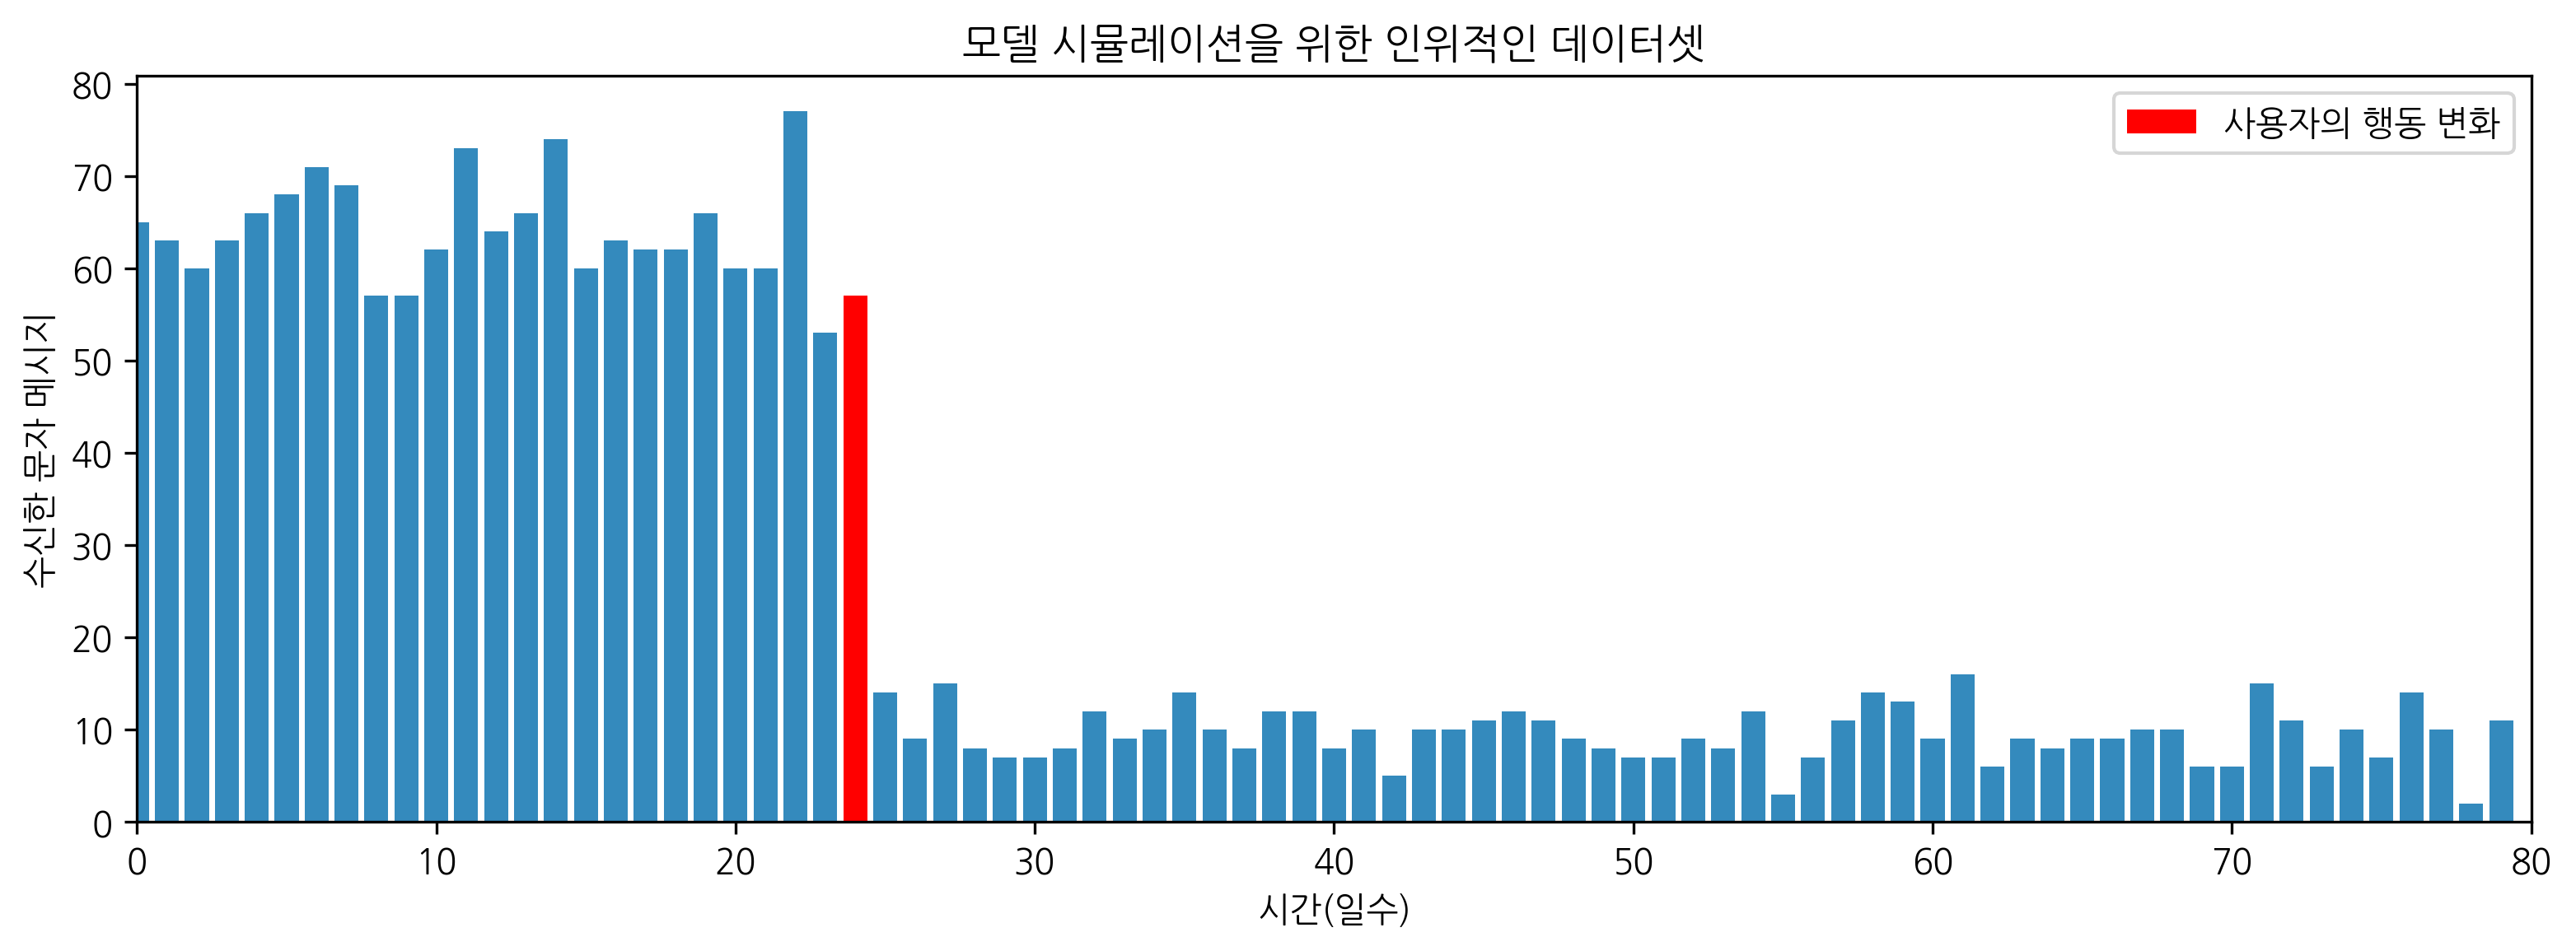

In [31]:
plt.bar(np.arange(80), data, color='#348ABD')
plt.bar(tau-1, data[tau-1], color='r', label='사용자의 행동 변화')
plt.xlabel('시간(일수)')
plt.ylabel('수신한 문자 메시지')
plt.title('모델 시뮬레이션을 위한 인위적인 데이터셋')
plt.xlim(0, 80)
plt.legend();

위에 그래프는 1장에서 보았던 결과와는 많이 다르다. 위의 데이터는 임의의 값을 가지고 시뮬레이션한 결과이며, `PyMC`모듈을 이용해 이러한 값 $(\lambda_i, \tau)$를 찾도록 설계되어있다. 

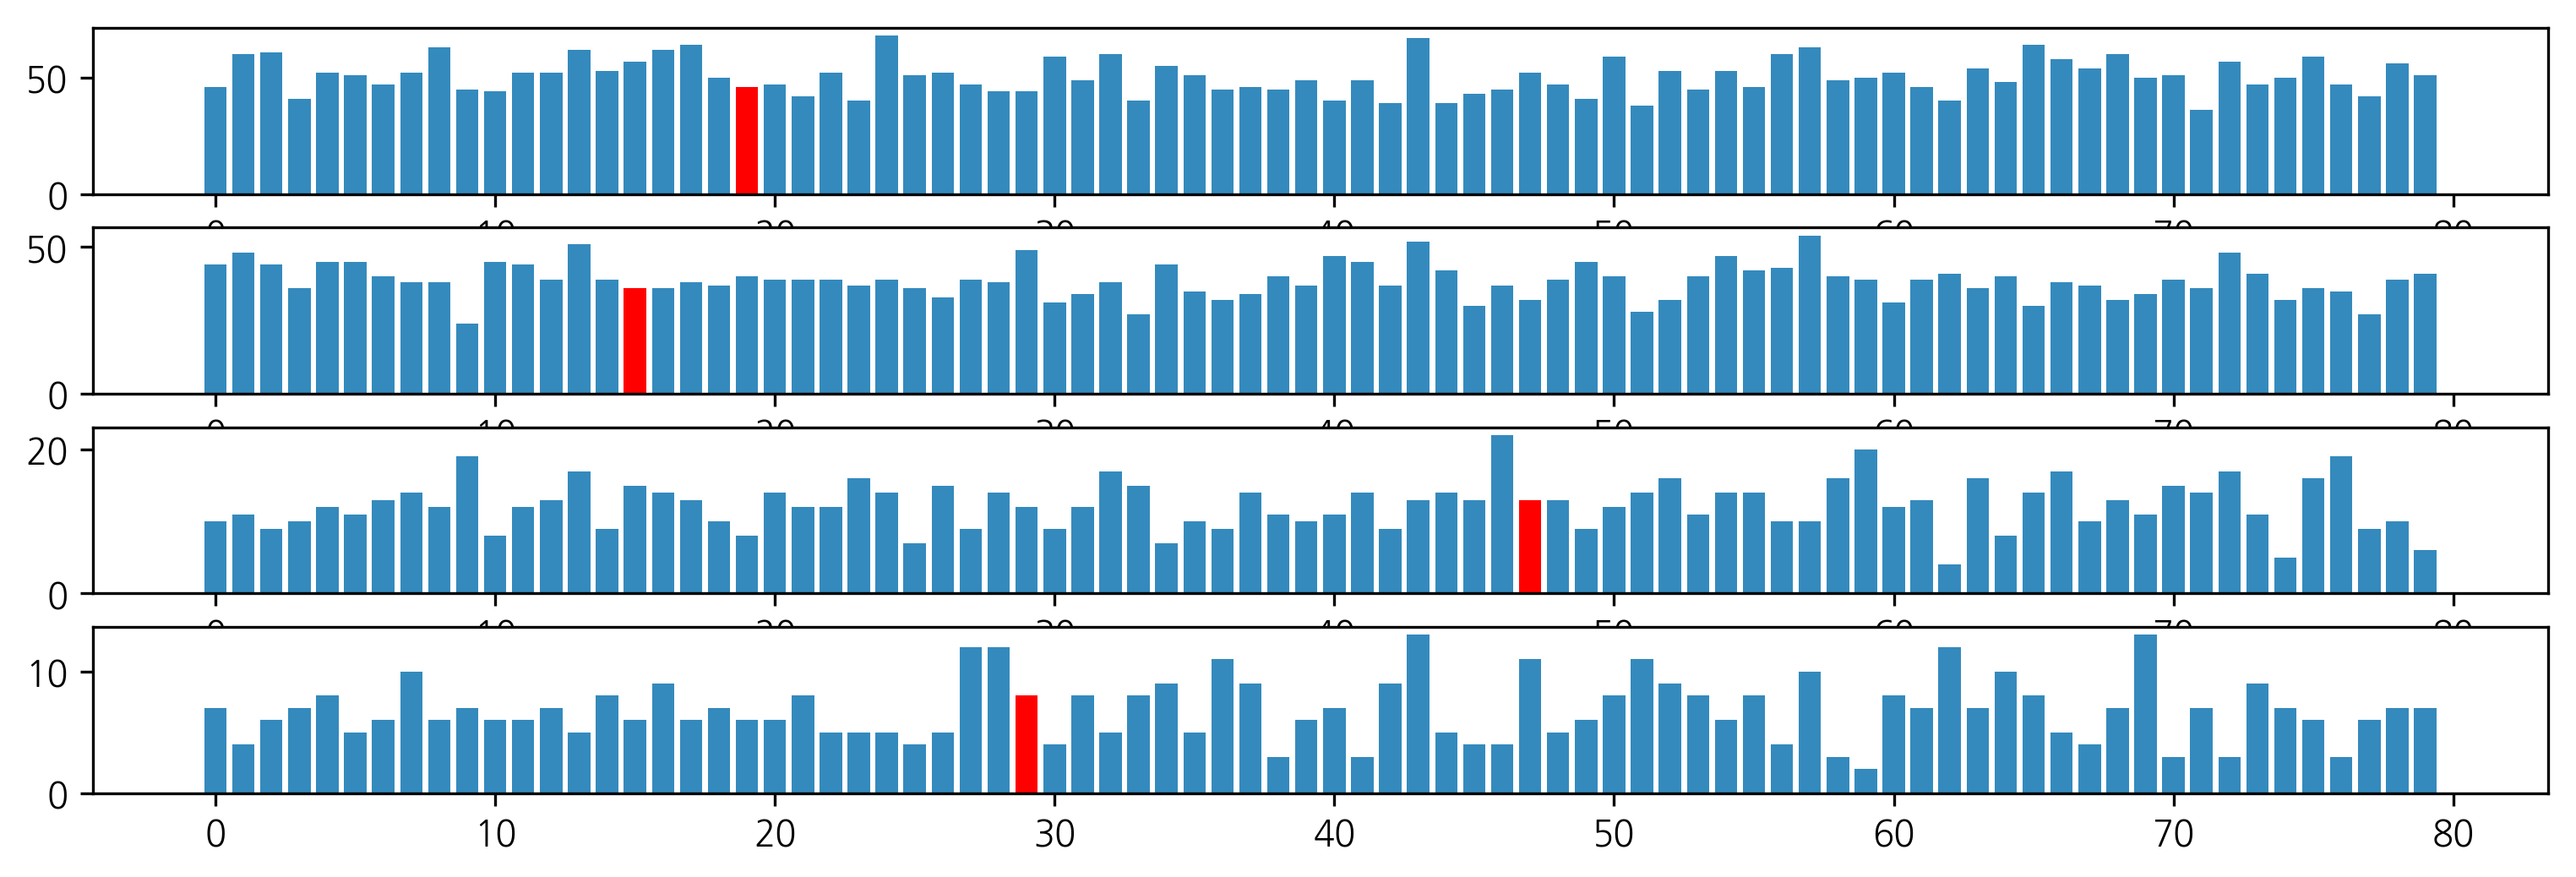

In [32]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_1, 80-tau)]
#     figsize(12.5, 5)
    plt.bar(np.arange(80), data, color='#348ABD')
    plt.bar(tau-1, data[tau-1], color='r', label='사용자의 행동 변화')
#     plt.xlabel('시간(일수)')
#     plt.ylabel('수신한 문자 메시지')
#     plt.title('모델 시뮬레이션을 위한 인위적인 데이터셋')
    
    
for i in range(4):
    plt.subplot(4, 1, i+1)
#     plt.xlabel('시간(일수)')
#     plt.ylabel('수신한 문자 메시지')
    plot_artificial_sms_dataset()

### 2.2.2 예제: 베이지안 A/B 테스트

A/B 테스트는 서로 다른 두 가지 방법 간의 효과의 차이를 밝히기 위한 통계적 디자인 패턴이다. 

> 예를 들어 어느 웹사이트 디자인이 더 많은 **전환율**(conversion)을 내는지 알고 싶어한다. 웹 개발자는 방문객의 일부는 A 사이트로 이동시키고, 나머지 방문객은 B 사이트로 이동시켜, 두 사이트의 전환율을 분석한다. 

A/B 테스트의 핵심은 그룹 간의 차이점이 단 하나뿐이라는 점이다. 따라서 측정값의 의미있는 변화가 바로 차이로 연결될 수 있다.

사후실험분석은 보통 **평균차이검정**(difference of means test)이나 **비율차이검정**(difference of proportion test)와 같은 **가설검정**(hypothesis test)라는 것을 사용한다. 

이번 장에서는 베이지안적으로 이 문제를 해결하는 방법에 대해 알아보자.

### 2.2.3 간단한 예제

위의 웹 개발 예제를 계속 살펴보자. 우선 A 사이트 분석에 초점을 맞춰 A 사이트에 노출된 사용자가 전환할 확률 $P_A$가 있다고 가정하자. 

A 사이트가 $N$명에게 노출되었고, $n$명이 전환했다고 가정하면, $P_A = \frac{n}{N}$ 이라고 결론 내릴지도 모른다. 하지만 **관측된 빈도** $\frac{n}{N}$이 반드시 $P_A$와 같은 것은 아니다. **관측된 빈도**와 사건의 **실제 빈도** 간에는 차이가 있다. 실제 빈도는 사건이 일어날 확률로 해석될 수 있으며, 이는 반드시 관측된 빈도와 같은 것은 아니다.
> 예를 들어 주사위를 던져 1이 나올 실제 확률은 $\frac{1}{6}$ 이지만, 주사위를 여섯 번 굴려서 1을 한번도 관측하지 못할 수도 있다(관측된 빈도).

우리는 노이즈와 복잡성(complexities)때문에 실제 빈도를 알지 못하므로 관측된 데이터로 실제 빈도를 **추론**해야 한다. 이것을 베이지안 통계를 사용하여 적절한 사전확률 및 관측된 데이터를 사용하여 실제 빈도의 추정값을 추론한다.위의 예제 같은 경우, 알고있는 $N$(총 방문자 수)과 $n$(전환한 사람 수)를 사용하여 $P_A$가 얼마인지 추정하고자 한다.

베이지안 모델을 설정하려면 사전확률분포를 할당해야 한다. $P_A$에 대한 확신이 뚜렷하지 않으므로, 지금은 $P_A$를 $[0, 1]$에 대한 균등분포로 가정하자.

In [33]:
# import pymc as pm

# 모수는 Uniform 범위 내이다.
p = pm.Uniform('p', lower=0, upper=1)
print(p.value)

0.696429789412806


이 예제에서 $P_A = 0.05$, A 사이트에 노출된 사용자 수 $N=1,500$라고 가정하자. 사용자가 구매를 했는지 안했는지 여부를 시뮬레이션 할 것이다. $N$번 시행하여 이를 시뮬레이션하기 위해 **베르누이분포**(Bernoulli distribution, Y/N와 같이 두 가지 상황만 일어나는 경우에 적용)를 사용한다. 베르누이분포는 이진확률변수(0 또는 1만 가능한)이고, 위의 예제의 관측치 또한 이진(전환/비전환)이므로 적합하다.

$X \sim Berp(p)$이면 $X$는 $p$의 확률로 1이고, $1-p$의 확률로 0이다. 우리는 실제 $P_A$를 알지 못하지만, 이것을 사용하여 가상의 데이터를 시뮬레이션한다.

In [34]:
# 상수 설정
p_true = 0.05  # 실제로는 이 값은 미지수이다.
N = 1500

# Berp(0.05)로 부터 N개의 베르누이 확률변수를 표본추출한다.
# 각 확률변수가 1일 확률은 0.05다.
# 이것은 데이터 생성 단계
occurrences = pm.rbernoulli(p_true, N)

print(occurrences)  # True=1, False=0
print(occurrences.sum())
# print(type(occurrences))

[False False False ... False False False]
67


In [35]:
# occurrences.mean은 n/N이다.
print('A 사이트에서 관측된 빈도는 얼마인가 {:.4f}'.format(occurrences.mean()))
print('실제 빈도와 같은가? %s' % (occurrences.mean() == p_true))

A 사이트에서 관측된 빈도는 얼마인가 0.0447
실제 빈도와 같은가? False


관측된 데이터를 `PyMC`의 `observed`변수에 합쳐 추론 알고리즘을 실행한다.

In [36]:
# 베르누이 관측치를 포함한다.
obs = pm.Bernoulli('obs', p, value=occurrences, observed=True)

# 3장에서 설명
mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 0.9 sec

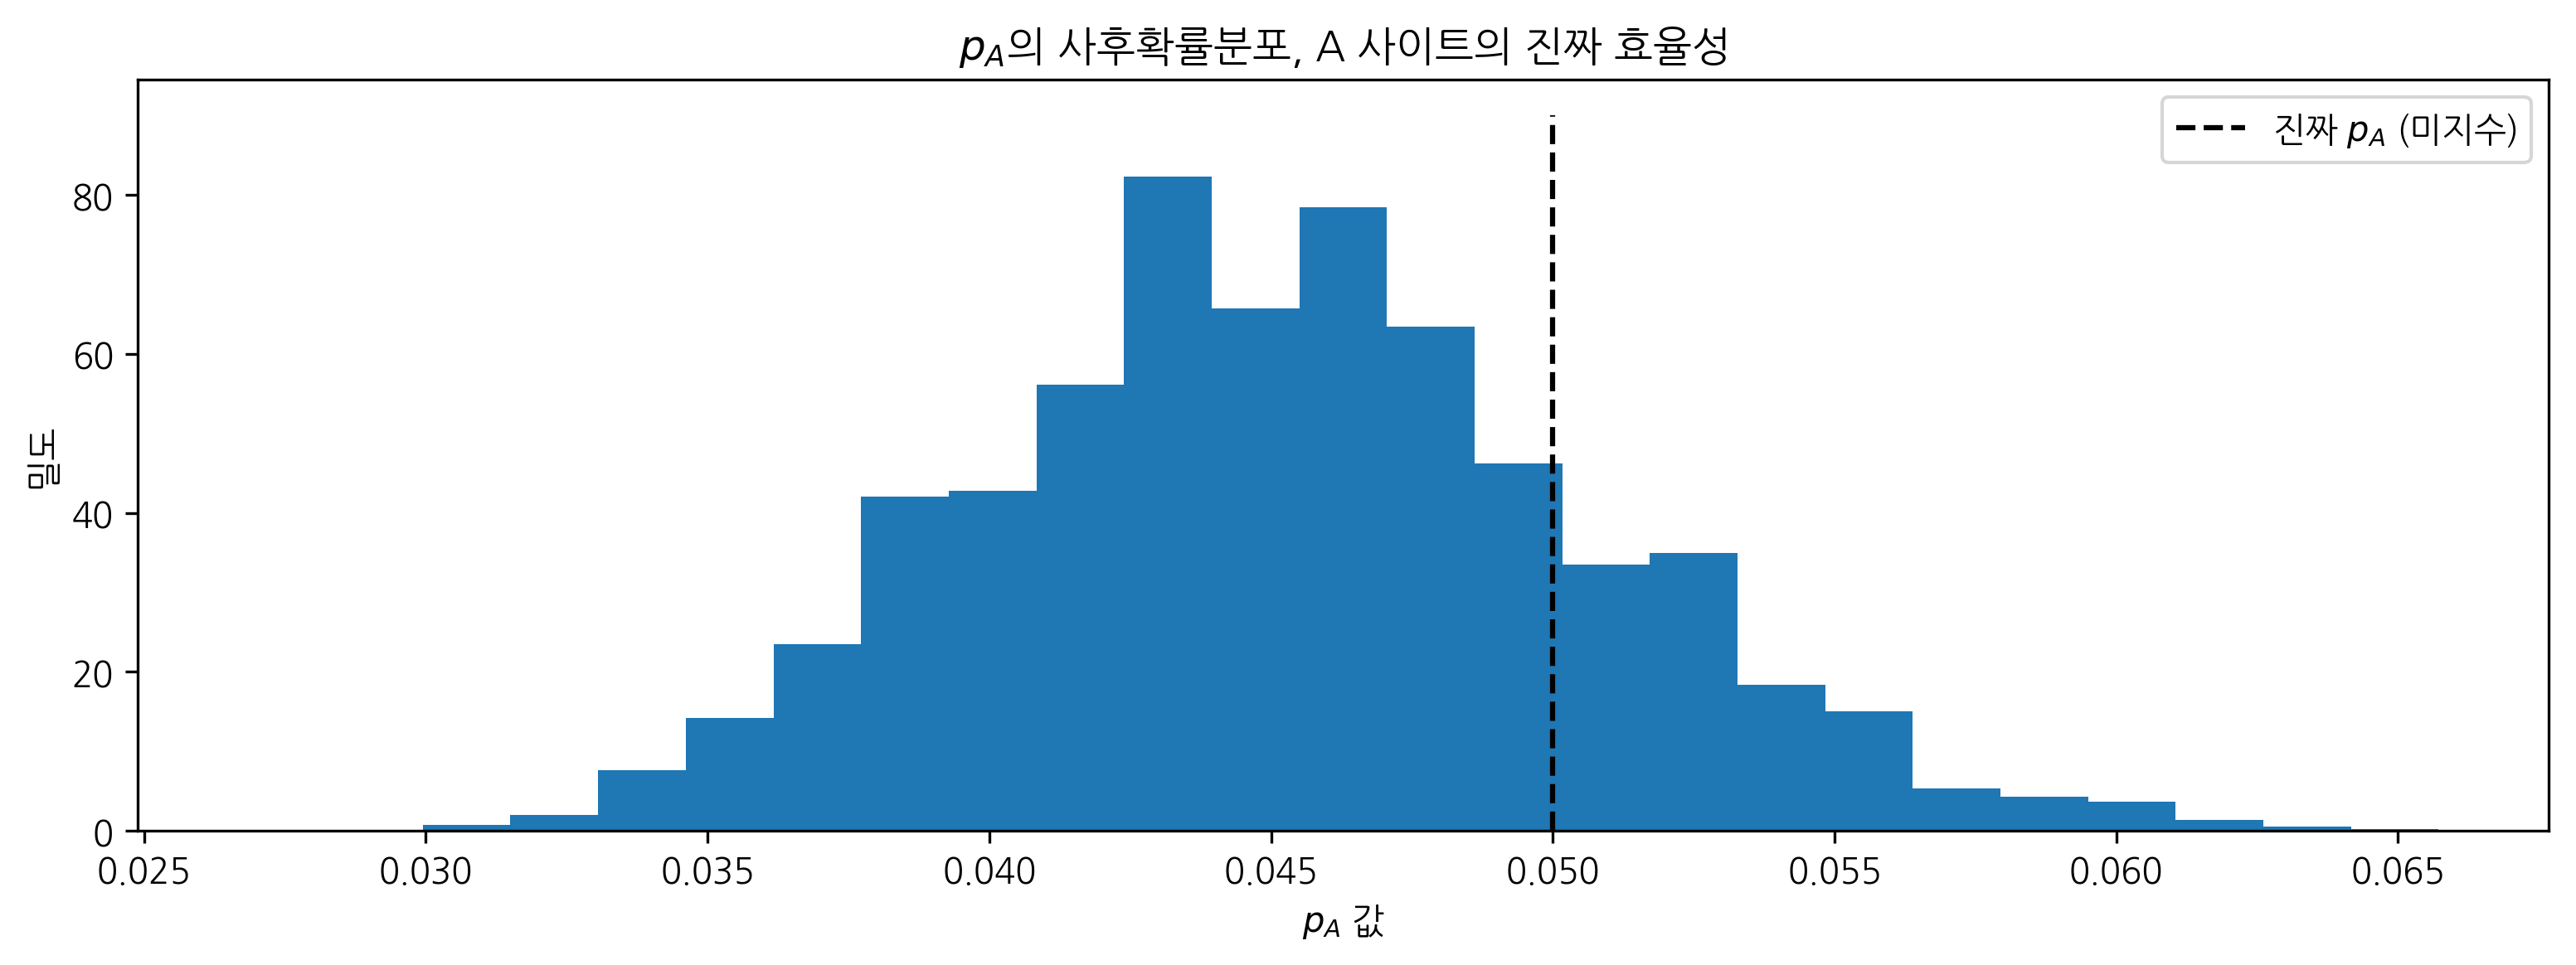

In [37]:
figsize(12.5, 4)
plt.title("$p_A$의 사후확률분포, A 사이트의 진짜 효율성")
plt.vlines(p_true, 0, 90, linestyle="--", label="진짜 $p_A$ (미지수)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", density=True)
plt.xlabel("$p_A$ 값")
plt.ylabel("밀도")
plt.legend();

### 2.2.4 A와 B를 묶어 보기

B 사이트의 데이터로 비슷한 분석을 수행하면 $P_B$의 사후확률분포를 알 수 있다. 우리가 정말로 알고싶은 것은 $P_A$와 $P_B$간의 **차이**이다. $P_A, P_B$ 그리고 $\delta = P_A - P_B$를 추론해보자. 

`PyMC`의 `deterministic` 변수를 사용하여 이를 추론할 수 있다. $P_B=0.04$ $\delta = P_A-P_B = 0.01$로 가정하자. 그리고 $N_B = 750$이라 하자.

In [38]:
figsize(12, 4)

# 다음 둘은 미지수다.
true_p_A = 0.05
true_p_B = 0.04

# 표본의 크기는 다르지만 베이지안 분석에서는 문제가 되지 않는다.
N_A = 1500
N_B = 750

# 관측치를 생성한다.
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print('Obs from Site A:', observations_A[:30].astype(int), '...')
print('Obs from Site B:', observations_B[:30].astype(int), '...')

Obs from Site A: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0] ...
Obs from Site B: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [39]:
print(observations_A.mean())
print(observations_B.mean())

0.04733333333333333
0.042666666666666665


In [40]:
# pmc 모델 설정. P_A와 P_B는 Uniform 사전확률로 가정한다.
p_A = pm.Uniform('p_A', 0, 1)
p_B = pm.Uniform('p_B', 0, 1)

# deterministic delta 함수 정의. 
# delta = p_A - p_B 이며, 우리가 알고자 하는 값이다.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# 관측치 설정. 이 경우 관측 데이터셋이 두 개 있다.
obs_A = pm.Bernoulli('obs_A', p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli('obs_B', p_B, value=observations_B, observed=True)

# 3장 설명 예정
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(25000, 5000)

 [-----------------100%-----------------] 25000 of 25000 complete in 1.8 sec

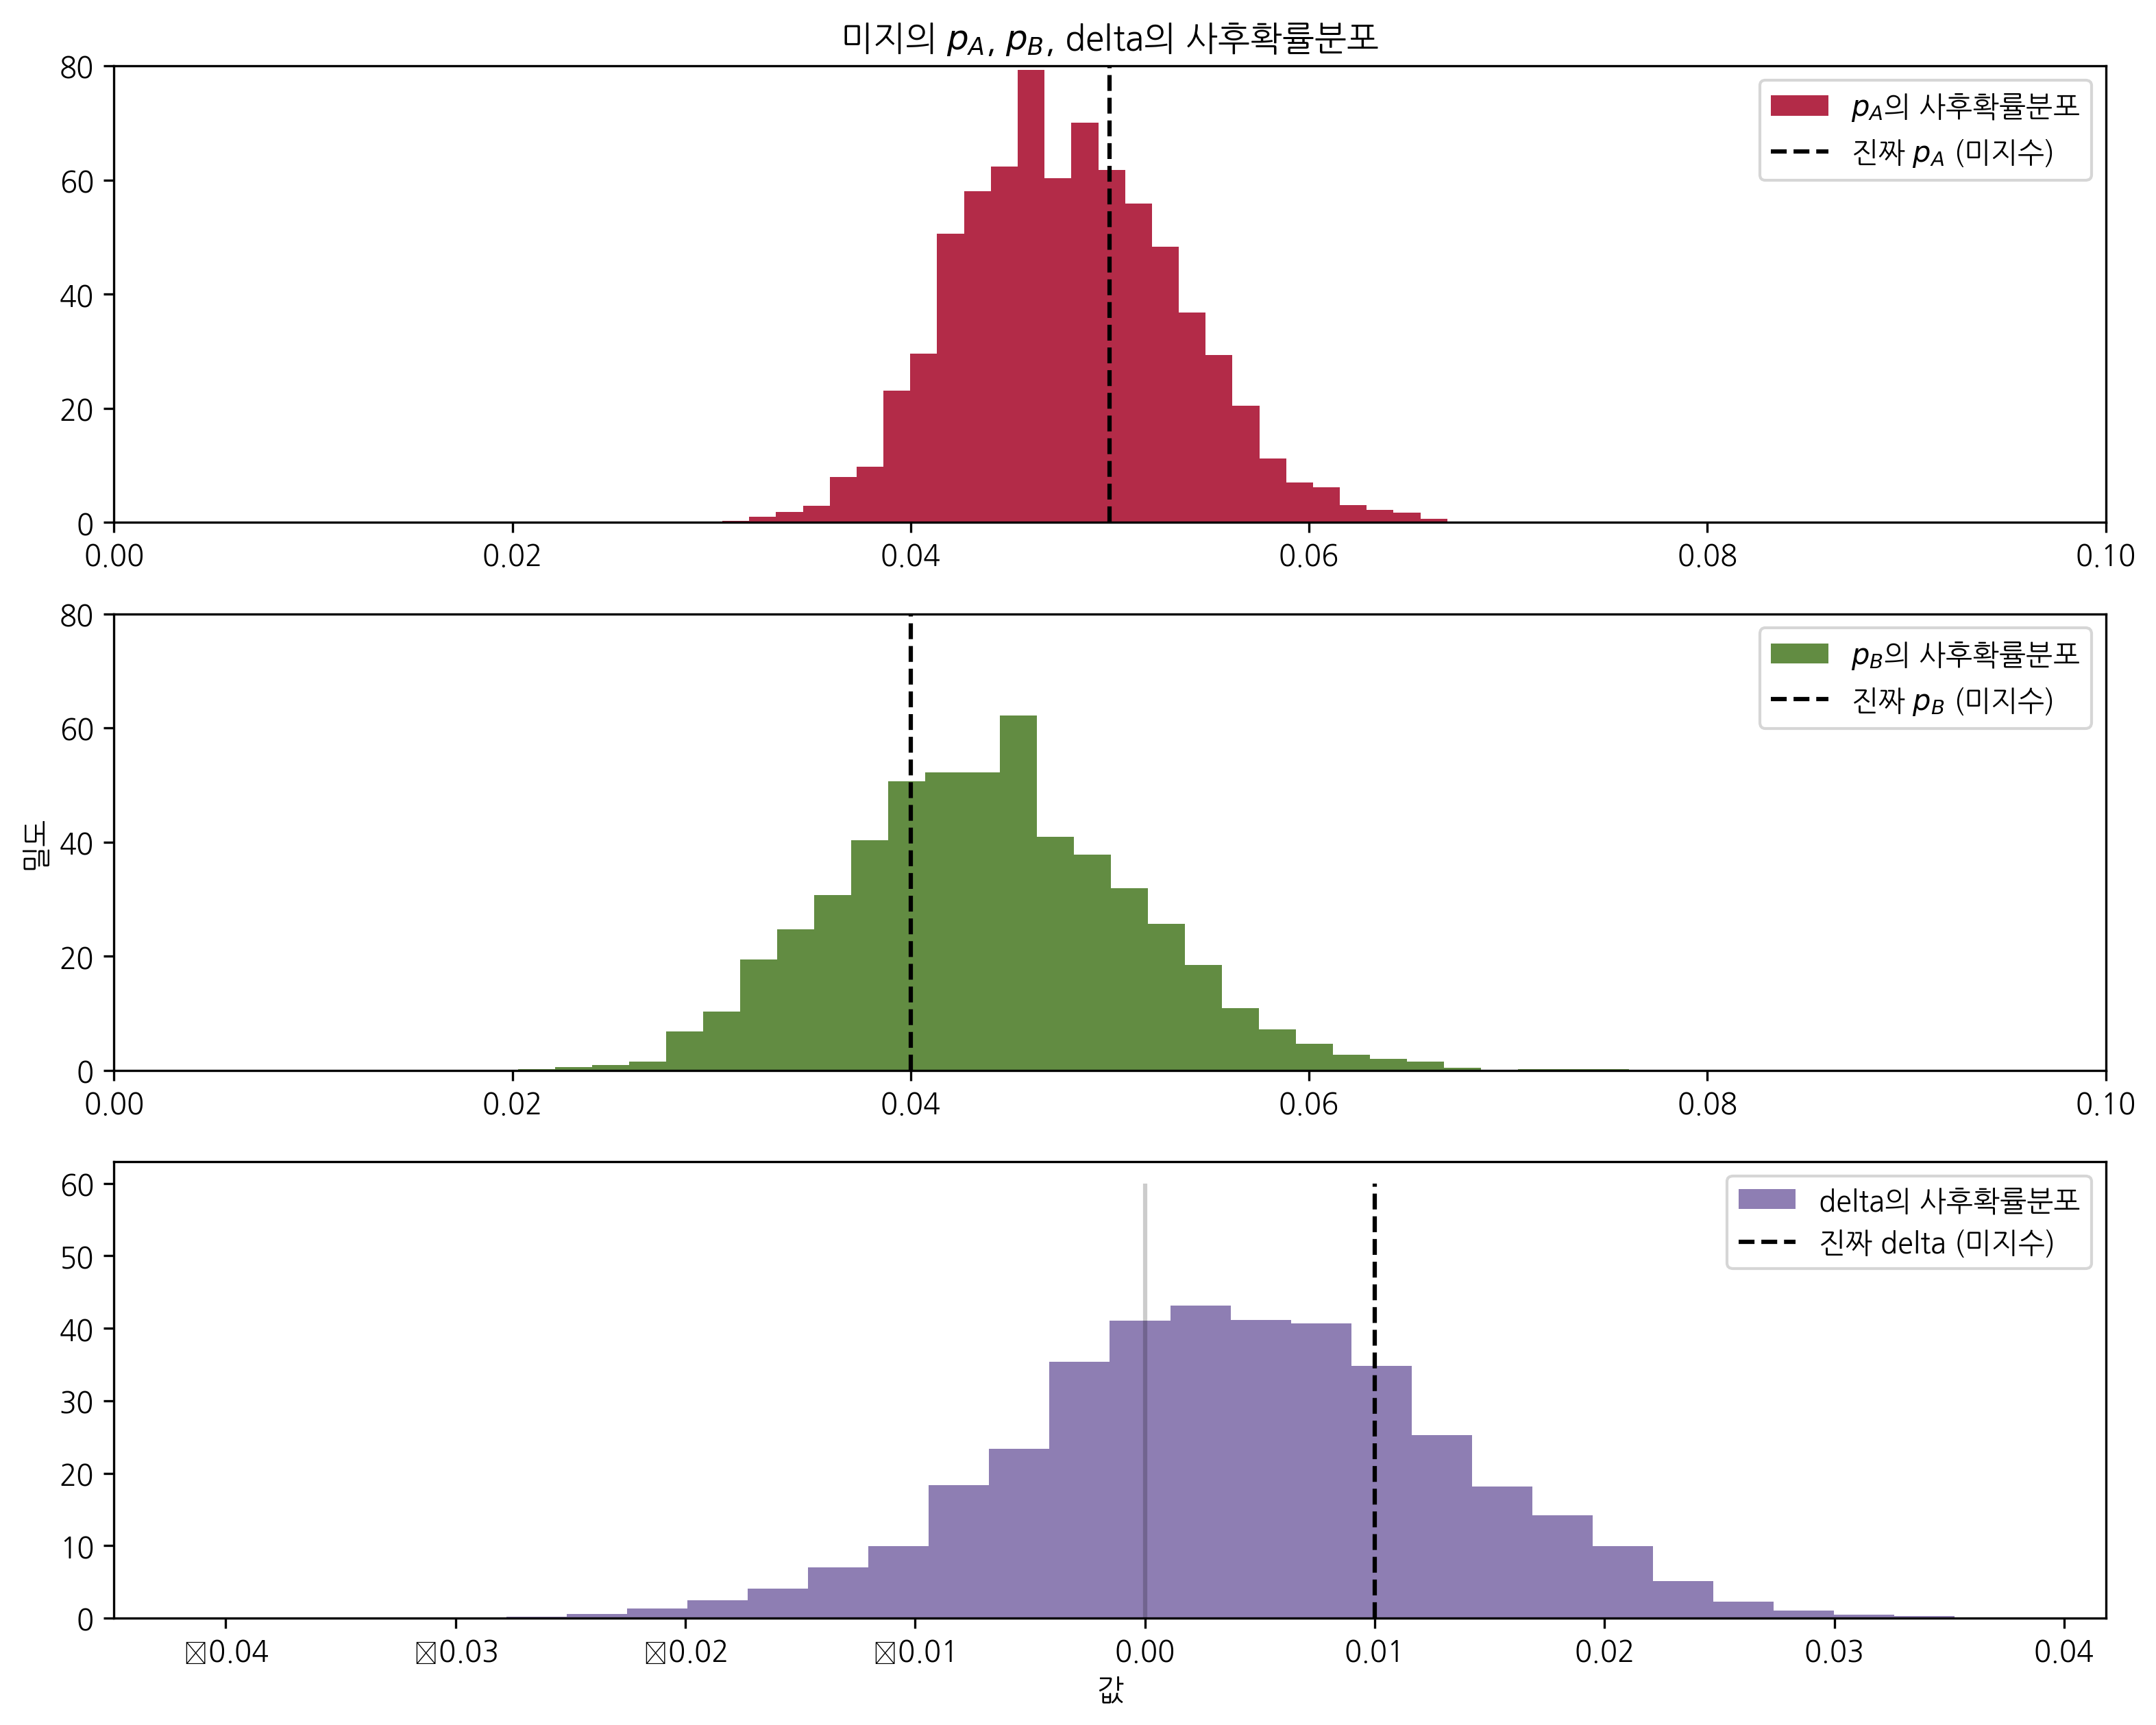

In [41]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

figsize(12.5, 10)

# 사후확률분포의 히스토그램
ax = plt.subplot(311)
plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="$p_A$의 사후확률분포", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="진짜 $p_A$ (미지수)")
plt.legend(loc="upper right")
plt.title("미지의 $p_A$, $p_B$, delta의 사후확률분포")
plt.ylim(0,80)

ax = plt.subplot(312)
plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="$p_B$의 사후확률분포", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="진짜 $p_B$ (미지수)")
plt.ylabel("밀도")
plt.legend(loc="upper right")
plt.ylim(0,80)

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="delta의 사후확률분포", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--", label="진짜 delta (미지수)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.xlabel("값")
plt.legend(loc="upper right");

N_B < N_A 이므로 $P_B$의 사후확률분포가 더 평평한데, 이는 $P_A$와 달리 $P_B$의 실제 값에 대한 확신이 부족하다는 것을 의미한다.

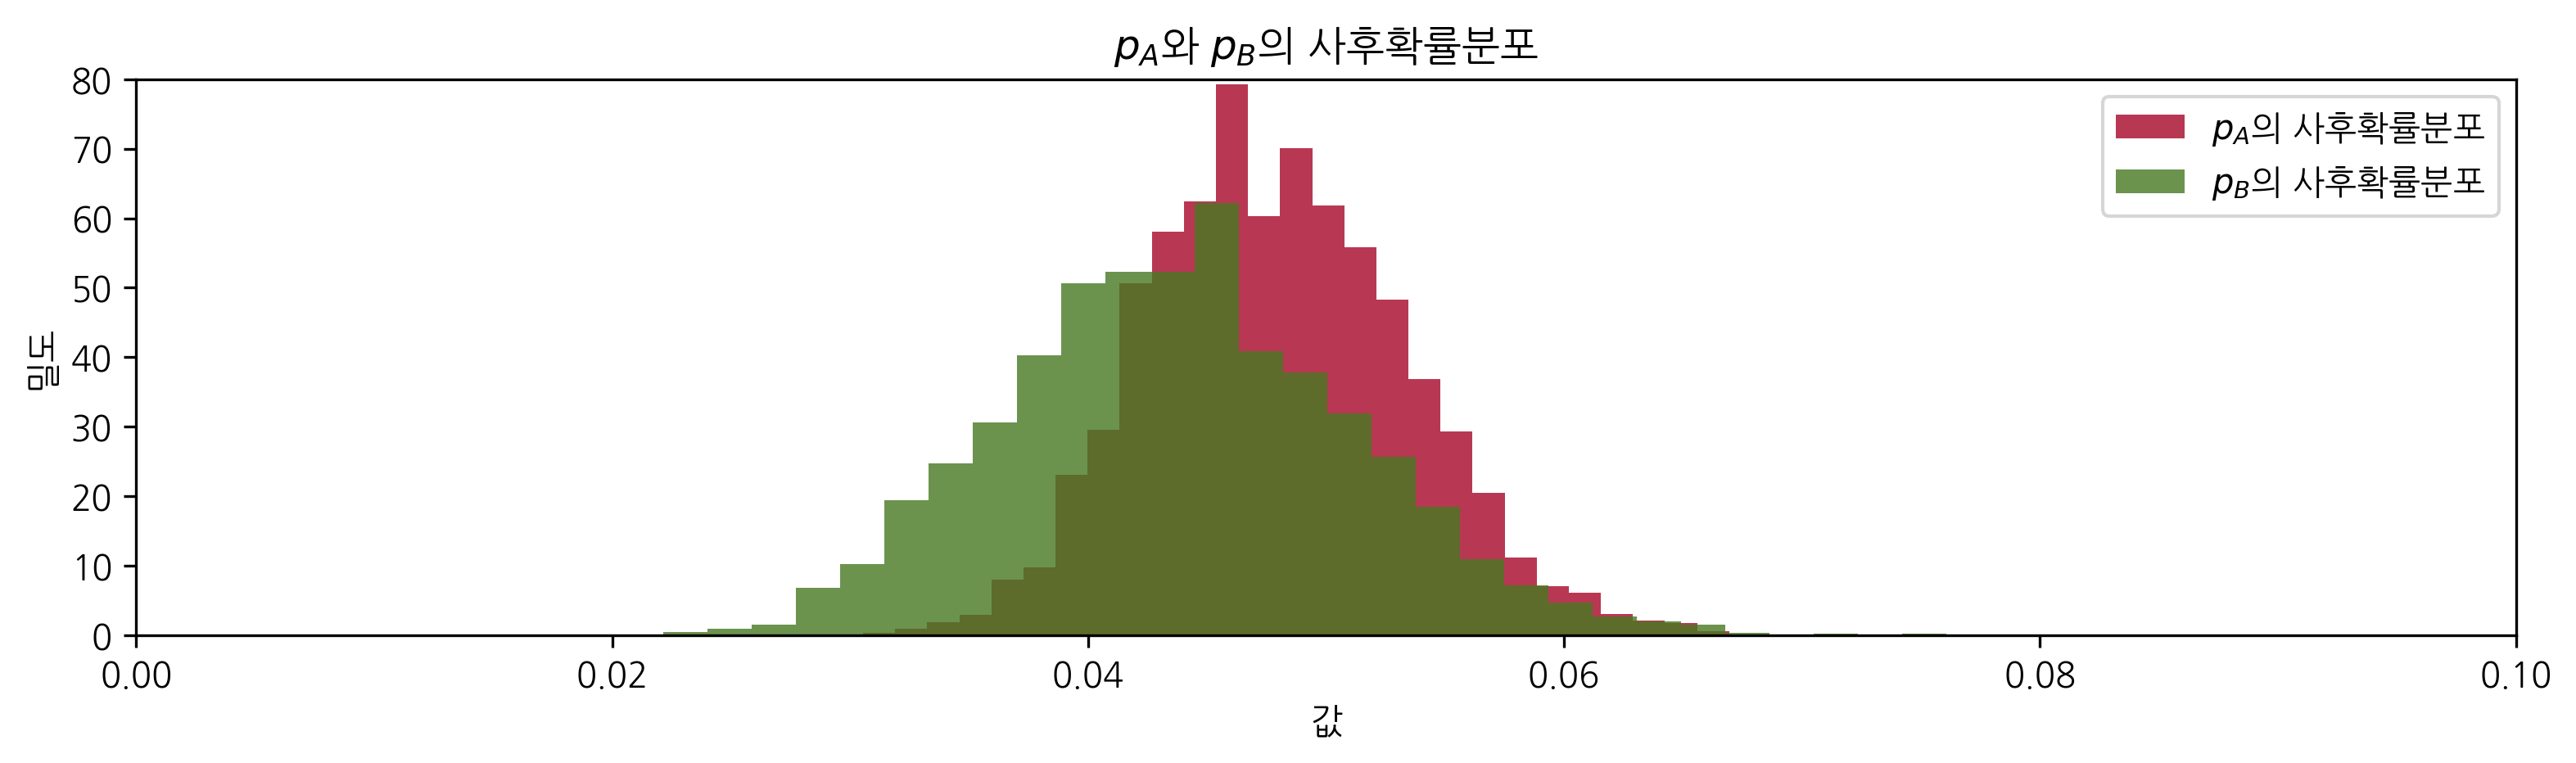

In [42]:
figsize(12.5, 3)
# 사후확률분포의 히스토그램
plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.80,
         label="$p_A$의 사후확률분포", color="#A60628", density=True)
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.80,
         label="$p_B$의 사후확률분포", color="#467821", density=True)
plt.legend(loc="upper right")
plt.xlabel("값")
plt.ylabel("밀도")
plt.title("$p_A$와 $p_B$의 사후확률분포")
plt.ylim(0,80);

위의 그림에서 delta($\delta$)의 사후확률분포 대부분이 $\delta = 0$ 이상임을 확인할 수 있다. 이것은 A사이트의 응답이 B사이트보다 낫다는 것을 의미한다. 이 추론이 부정확할 확률은 다음과 같이 계산할 수 있다.

In [43]:
# 0이하 표본의 개수를 센다. delta = P_A - P_B 이므로
# 0 이하 영역은 A 사이트가 B 사이트보다 나쁠 확률을 의미한다.
print('A 사이트가 B 사이트보다 나쁠 확률: %.3f' % (delta_samples < 0).mean())
print('A 사이트가 B 사이트보다 나을 확률: %.3f' % (delta_samples > 0).mean())

A 사이트가 B 사이트보다 나쁠 확률: 0.329
A 사이트가 B 사이트보다 나을 확률: 0.671


*2.2.5 생략*

### 2.2.6 이항분포 - Binomial distribution

이항분포는 두 개의 모수, $N$과 $p$를 가진다.

- $N$ : 양의 정수로 시행의 수 또는 가능한 사건의 경우의 수를 의미한다. 
- $p$ : 한 번 시행했을 때 사건이 일어날 확률이다. 

$$
P(X=k)=\left( \begin{matrix} N \\ k \end{matrix} \right)p^k (1-p)^{-k}
$$

만약, $X$가 $p$와 $N$을 모수로 가진 이항확률변수 $X \sim Bin(N,p)$라면 $X$는 $N$번의 시행($0 \le X \le N$)에서 발생하는 사건의 수다. $p$가 클수록 ($0 \le p \le 1$) 사건이 일어날 가능성이 커진다. 

$$
E(X) = np
$$
$$
Var(X) = np(1-p)
$$

베르누이 확률변수 $X_1, X_2, \dots , X_N$이 있다면 $Z=X_1 + X_2 + \cdots + X_N$은 모수가 $N$과 $p$인 이항분포를 따른다.

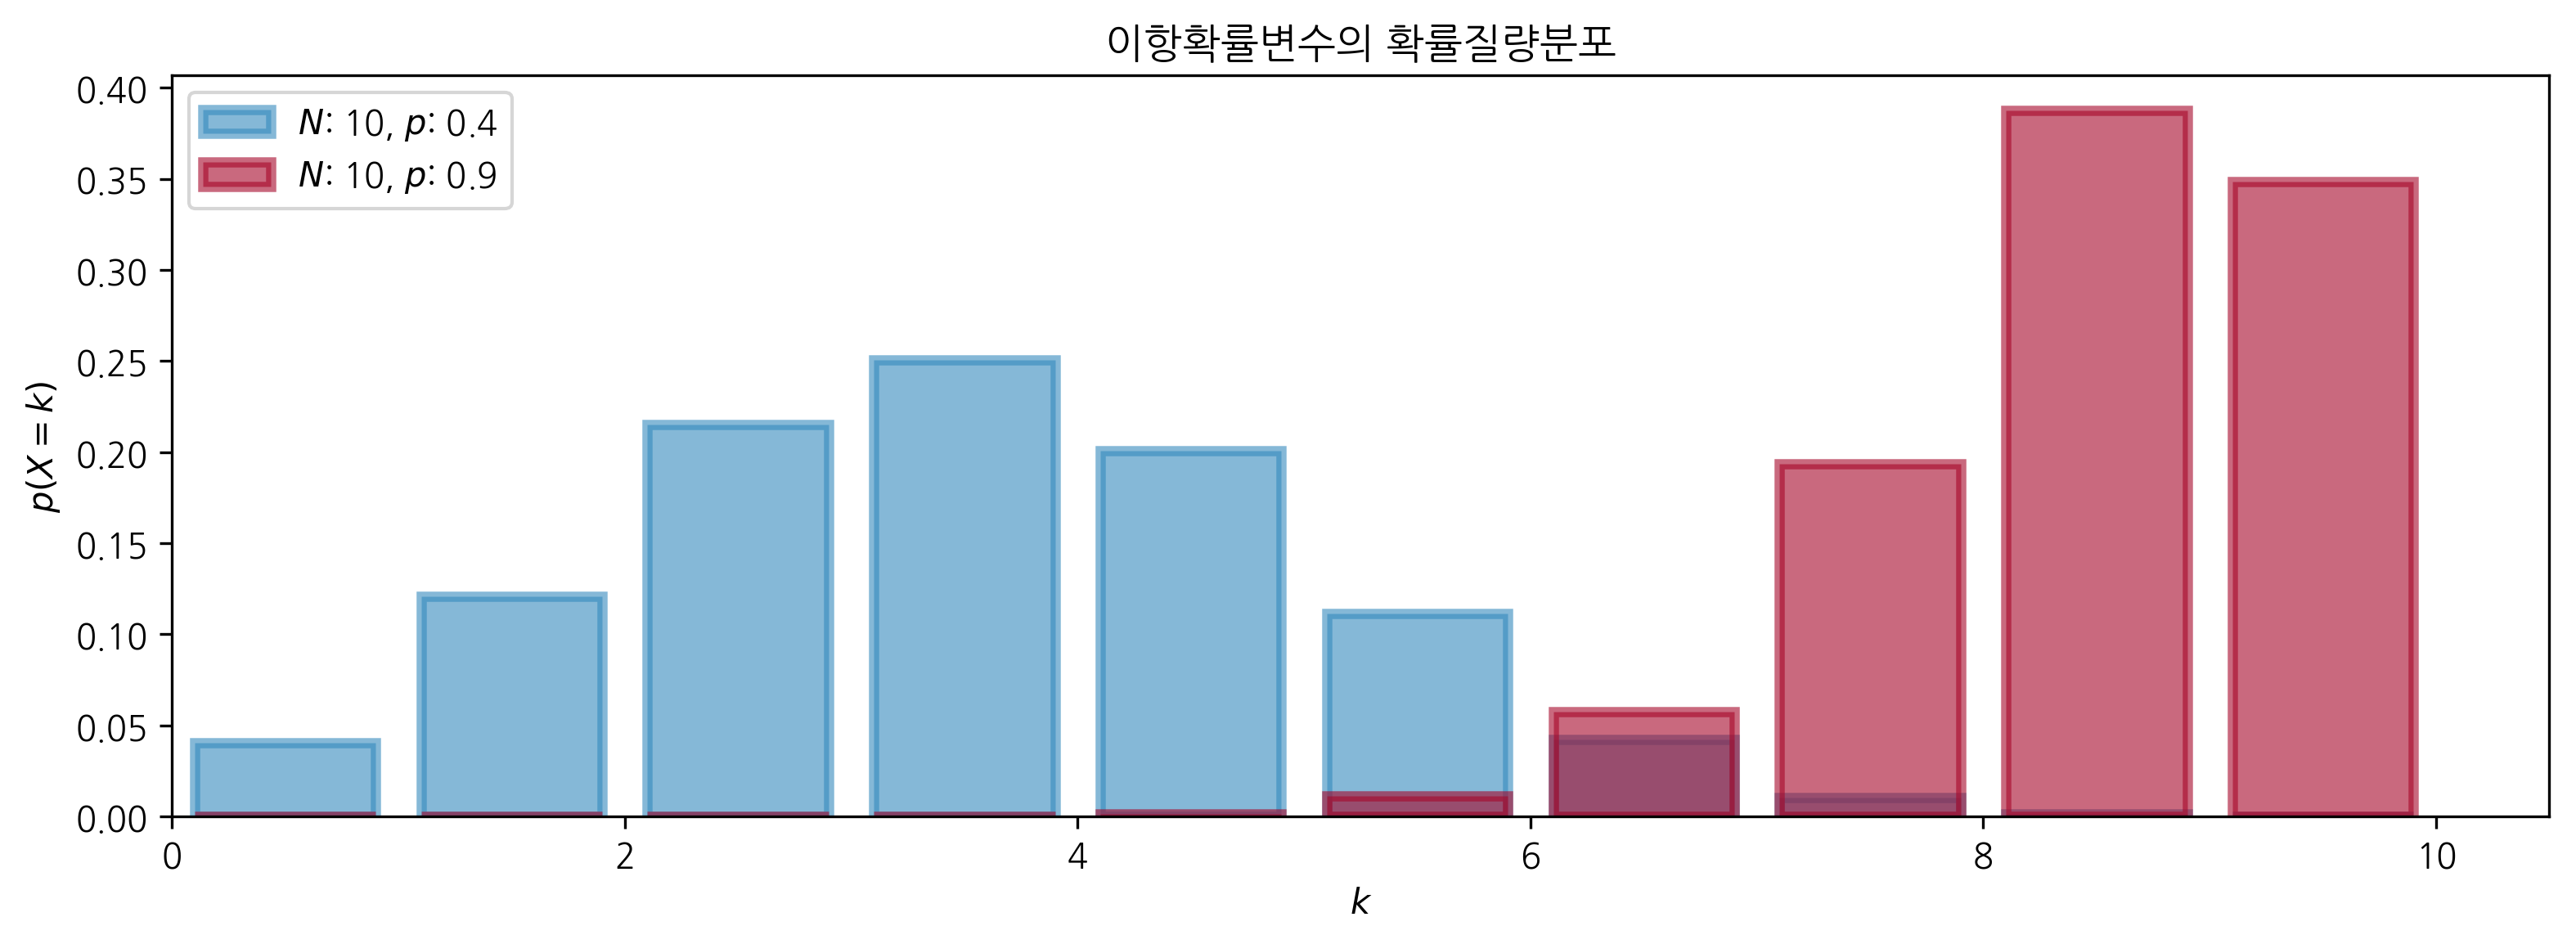

In [44]:
figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ['#348ABD', '#A60628']

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i], edgecolor=colors[i], 
            alpha=0.6, label='$N$: %d, $p$: %.1f' % (N, p), linewidth=3)
    
    plt.legend(loc='upper left')
    plt.xlim(0, 10.5)
    plt.xlabel('$k$')
    plt.ylabel('$p(X=k)$')
    plt.title('이항확률변수의 확률질량분포')

### 2.2.7 예제: 학생들의 부정행위

위에서 살펴본 이항분포를 사용하여 학생들이 시험 중에 부정행위를 저지르는 빈도를 구하는 예제를 살펴보자. 

- $N$ : 시험을 응시한 총 학생수
- $X$ : 부정행위를 한 학생 수
- $p$ : 부정행위자의 비율

위에서 주어진 $N$, $p$에 대한 일부 정해진 사전분포, 관찰된 데이터 X를 알면 $p$의 사후확률분포를 얻을 수 있다.

> 학생들은 인터뷰할 때 각자 숨겨둔 동전을 하나 던진다. 인터뷰하는 사람은 모른다. 동전의 앞면이 나온 학생은 
정직하게 대답한다. 동전의 뒷면이 나온 학생은(몰래) 동전을 다시 던져 앞면이 나오면 “네, 부정행위를 했습니다
”라고 대답하고, 뒷면이 나오면 “부정행위를 하지 않았습니다”라고 대답하는 것에 동의한다. 이런 방법을 사용하
면 인터뷰하는 사람은 “예”라는 답변이 부정행위를 인정한 진술의 결과인지 아니면 두 번째 동전 던지기에서 앞
면이 나온 결과인지 모른다. 그래서 프라이버시는 지켜지고 연구자는 정직한 답변을 받는다.

부정행위에 대해 학생 100명을 조사한다고 가정하자. 우리는 부정행위자의 비율인 $p$를 찾으려 한다. 이를 $PyMC$에서 모델링하는 방법이 몇가지 있다. $p$에 대해 전혀 모르므로 $p$의 사전확률로 `Uniform(0, 1)`을 부여한다.

In [46]:
# import pymc as pm

N = 100
p = pm.Uniform('freq_cheating', 0, 1)
print(p.value)

0.7901781990111342


학생 100명에게 베르누이 확률변수를 할당한다. 1은 부정행위, 0은 부정행위를 하지 않았다는 것을 의미한다.

In [47]:
true_answers = pm.Bernoulli('truths', p, size=N)
print(true_answers.value)

[False  True  True False False  True  True  True  True  True  True  True
 False  True False  True  True  True  True  True False False  True False
  True False  True  True  True  True  True False  True  True  True  True
  True False  True  True  True False  True  True  True  True  True  True
 False  True False  True  True  True  True  True  True False False  True
  True False  True  True False  True  True  True  True  True  True False
  True  True False False  True  True  True  True  True  True False False
  True  True  True  True  True  True False  True False  True  True  True
  True False False  True]


이제 각 학생이 시행하는 첫 번째 동전 던지기이다. $p = \frac{1}{2}$를 사용해 베르누이 확률변수 100개를 표본추출하여 이 단계를 다시 모델링 할 수 있다. 1은 앞면, 0은 뒷면이다.

In [48]:
first_coin_flips = pm.Bernoulli('first_flips', 0.5, size=N)
print(first_coin_flips.value)

[False  True False False  True  True False  True  True False False False
 False False False False  True False  True  True  True  True False  True
  True False False False  True False False  True False  True  True  True
  True  True  True False  True  True False  True False False False False
 False False False  True False False False  True  True False False False
  True False False False False  True False  True False False False False
 False False False  True False  True  True False  True False  True False
 False False False  True  True False  True  True False  True  True False
  True  True  True False]


처음 동전 던지기에서 뒤면이 나온 학생은 두 번째 동전 던지기를 시행한다.

In [49]:
second_coin_flips = pm.Bernoulli('second_flips', 0.5, size=N)

이러한 변수를 사용해서 "예"라는 답변이 관측된 비율의 결과추정치를 얻을 수 있다. `PyMC`의 `deterministic` 변수를 사용하여 비율을 얻을 수 있다.

In [50]:
@pm.deterministic
def observed_proportion(t_a=true_answers, fc=first_coin_flips, sc=second_coin_flips):
    observed = fc * t_a + (1-fc) * sc
    return observed.sum() / float(N)

print('observed_proportion:', observed_proportion.value)

observed_proportion: 0.59


In [51]:
X = 35

observations = pm.Binomial('obs', N, observed_proportion, observed=True, value=X)

model = pm.Model([p, true_answers, first_coin_flips, second_coin_flips, observed_proportion, observations])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 15000)

 [-----------------100%-----------------] 40000 of 40000 complete in 5.7 sec

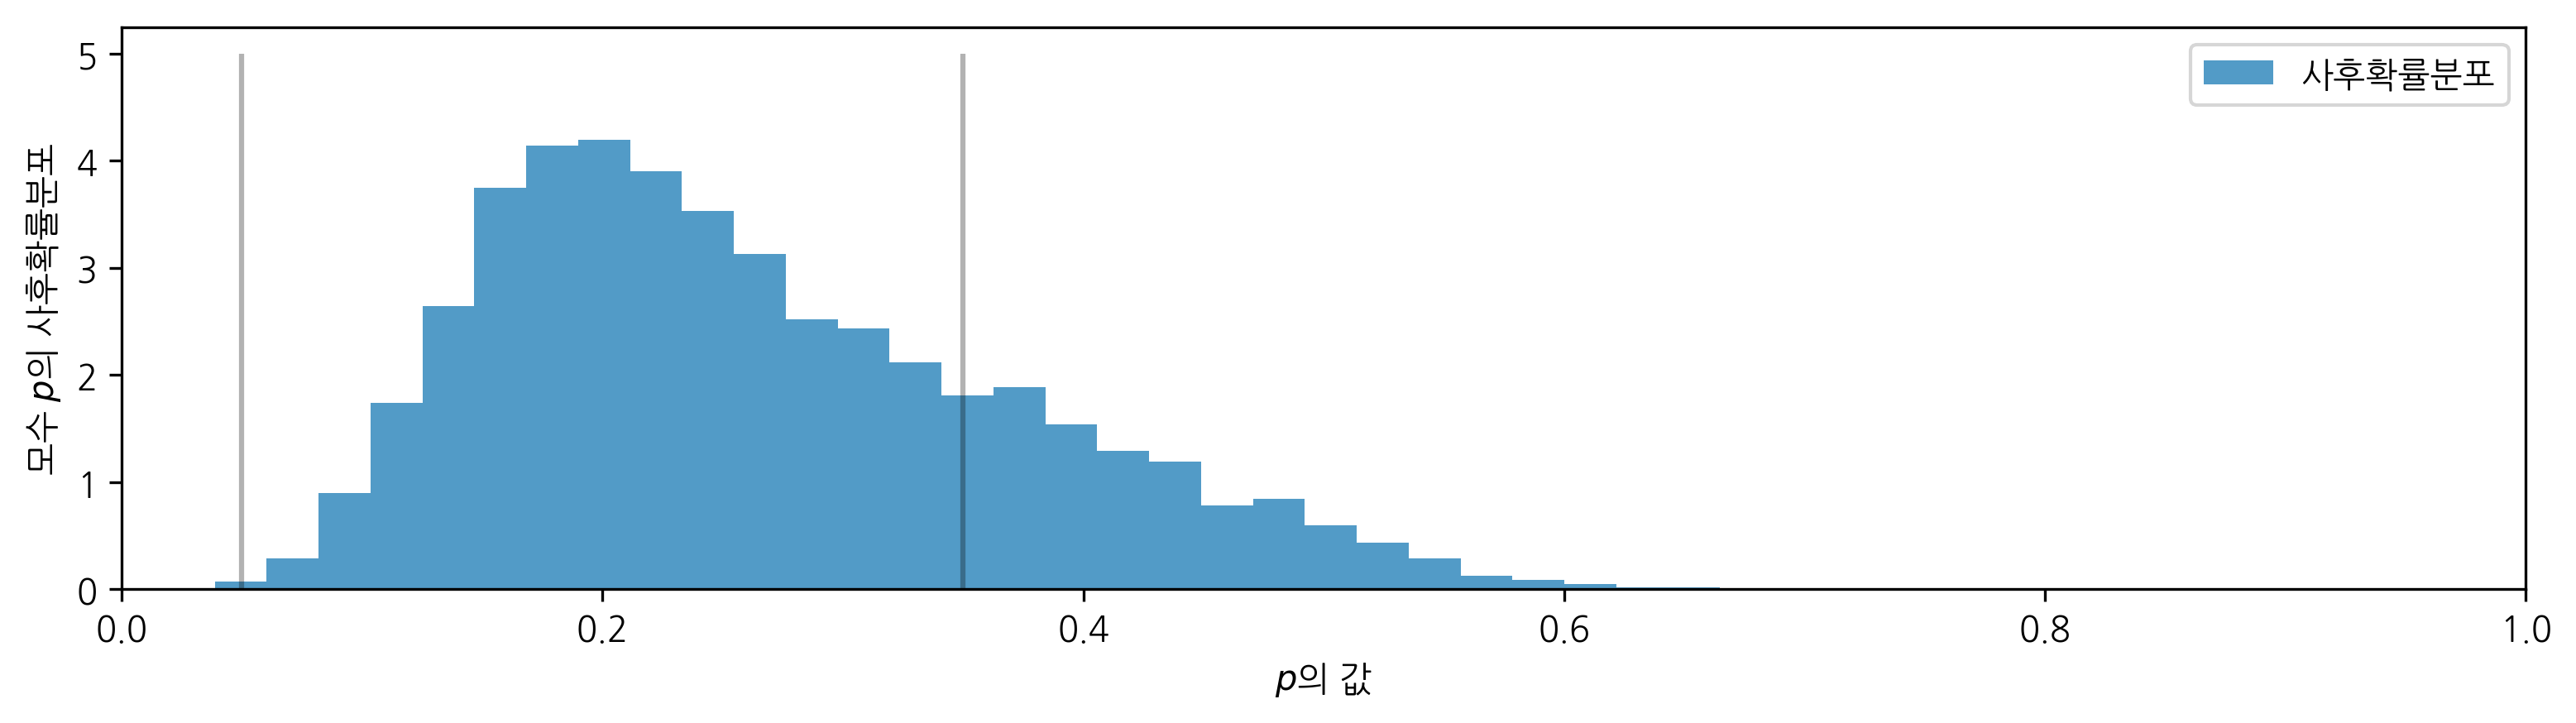

In [53]:
figsize(12.5, 3)

p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, 
         bins=30,label="사후확률분포", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.xlabel("$p$의 값")
plt.ylabel("밀도")
plt.ylabel("모수 $p$의 사후확률분포")
plt.legend();